## Summarizing recommended sample sizes for classification

#### Leyla Tarhan
#### 7/2020

#### Output: plot that shows a recommended sample size for a range of effect sizes

##### recommended sample size: 
minimum amount of data per category to detect a real difference in the data. Based on the smallest sample size where a classifier does significantly better than baseline. To make sure this isn't just a blip, require that the next 5 sample sizes are also significantly better than baseline (otherwise, recommend a larger sample size). 

##### effect sizes: 
really the distance between the two categories' underlying multivariate distributions. Calculated as the euclidean distance between the distributions' means, divided by their standard deviations. 

In [11]:
## clean up

try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass


In [12]:
## import libraries

# !pip install -U scikit-learn
# !pip install opencv-python

# data wrangling:
import numpy as np
import pandas as pd
import itertools
from copy import deepcopy as dc
from scipy.spatial import distance

# math:
from sympy import Eq, var, solve
import statistics
import math
from scipy import stats

# plotting:
import matplotlib.pyplot as plt
import seaborn as sns

# SVM:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2



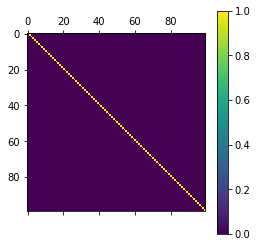

In [13]:
## General Setup

# data
nVox = 100 # number of voxels (or other dimensions)
sd = 1 # standard deviation of the distributions (keeping this the same for all distributions)
nIters = 100 # how many times you sample data of each size
nCats = 2 # how many categories you're classifying 

# training-testing split for classification analyses:
trainProp = .8 # 80% of data in each category used for training
testProp = .2 # 20% used for testing

# possible sample sizes
minN = 10
maxN = 100
nRange = range(minN, maxN+1)

# set up variance-covariance matrix for the multi-variate normal distributions:
covMat = np.identity(nVox)*sd**2 # orthogonal dimensions; main diagonal = s.d.^2 (variance)
# plot it to check -- main diagonal should = sd^2, all other values should = 0
plt.matshow(covMat);
plt.colorbar()
plt.show()


# seed a random number generator:
np.random.seed(444)

#### Set up the possible effect sizes

###### general method:
...fix the multivariate mean for category 1 to 1.
...set up a range of possible multivariate means for category 2 (from 1.1 to 3)
...for each of category 2's possible mean values, calculate the distance between the category 1 and 2 distributions, and treat that as the "effect size" of the difference between them. 

N.B.: Ideally, you'd specify a range of possible distances between the categories and solve for category 2's vector for each distance. But I couldn't find a straightforward way to do this, so instead just sampling a lot of possible distributions for category 2.

###### calculating distance between distributions:
To estimate the size of this difference, calculate the euclidean distance between the means and then scale that by the standard deviation of the distributions (intuitively: a larger standard deviation = closer distributions if you don't change the means)

In [14]:
## Set up possible effect sizes

# multivariate means for each category
popMean1 = 1 # fixed at 1
cat1Means = np.full((nVox), popMean1) # vector of means for this category length = # voxels (dimensions)
# range of possible means for category 2
popMean2Range = np.arange(popMean1+.1, 3+.1, .1)


# function to calculate the distance between the categories' multivariate distributions    
def calcDist(vec1, vec2):
    # numerator: euclidean distance between mean vectors:
    d = distance.euclidean(vec1, vec2)
    
    # denominator: variance of the distributions (which is set up to be the same for both distributions):
    var = sd**2
    
    return d/var



#### Set up the procedure for selecting a reasonable suggestion for the minimum amount of data

##### general procedure:
...compare classifier accuracy to baseline at every sample size (independent-samples t-test)

...figure out which sample sizes are significantly > baseline

...figure out the smallest significant sample size that's not just a blip -- some number of samples 
above it also have to be significant

...if there are no cases like this, default to suggesting the highest considered sample size

In [15]:
## Set up procedure for selecting a "good" minimum amount of data

# decision boundary for considering classification accuracies to be significant:
maxP = 0.001;

# minimum size of the "run" of significant results to make sure the recommendation isn't just a blip:
runLength = 5;

# helper function
def findSuggestion(intactDict, scrambledDict, maxP, runLength):
    # get all the sample sizes we considered:
    samples = list(intactDict.keys());
    
    # loop through the samples:
    sigOrNot = {}; # store whether each sample size passes the significance threshold vs. baseline
    for s in samples:
        # get the intact accuracies:
        intactAcc = intactDict[s]; # all classification accuracies for this sample size
        scramAcc = scrambledDict[s]; # all baseline accuracies for this sample size
        
        # compare with independent-samples t-test:
        [t, p] = stats.ttest_ind(intactAcc, scramAcc)
        
        # assess whether it passes the significance threshold:
        if p < maxP:
            sigOrNot[s] = 1;
        else:
            sigOrNot[s] = 0;
            
    # find the smallest sample size that's significant and not a blip:
    sigSamples = [k for k in sigOrNot.keys() if sigOrNot[k] == 1] # get all the significant samples
    suggestion = max(samples) # default to highest sample size we considered
    done = 0;
    while not done and len(sigSamples) > 0:
        
        # find smallest value that's significant:
        currSuggestion = min(sigSamples)
        
        # check if it's part of a run:
        runMembers = range(currSuggestion, currSuggestion+runLength+1) # what would the next n sample sizes be?
        if all(item in sigSamples for item in runMembers): # next n sample sizes are also significant
            suggestion = currSuggestion; # update the suggestion
            done = 1;
            break
        else: # run didn't hold -- move on to the next significant option
            # remove this suggestion from the list of possibilities, and start again
            sigSamples.remove(currSuggestion)
            
    return suggestion        
        



In [16]:
## loop through the possible effect sizes
# on each loop, use a different distribution for category 2

# set up a dictionary to store the suggested sample size for each effect size
suggestionDict = {}

# display progress:
from IPython.display import clear_output
clear_output(wait=True)
mCount = 1;

for m in popMean2Range:
    print('\n\ncomparison ' + str(mCount) + '/' + str(len(popMean2Range)) + '...')
    
    # get the multivariate means vector for category 2
    cat2Means = np.full((nVox), m)

    # loop through the sample sizes:
    accuracyDict = {};
    accuracyDictScram = {};
    
    for n in nRange:
        print('Estimating classification accuracy with ' + str(n) + ' samples / category')
        currAccuracy = [] # set up an array to store classification accuracy for this sample size
        currAccuracyScram = [] # set up an array to store classification accuracy for scrambled data with this sample size

        # loop through the iterations for this sample size
        for i in range(nIters):
            # sample from both categories:
            cat1Patterns = np.random.multivariate_normal(cat1Means, covMat, n) # category 1: sample size x voxels
            cat2Patterns = np.random.multivariate_normal(cat2Means, covMat, n) # category 2: sample size x voxels

            # put the categories together:
            allCatsPatterns = np.concatenate((cat1Patterns, cat2Patterns)) # sample size * 2 categories x voxels

            # set up the labels for the classifier:
            labels = []
            for c, s in itertools.product(range(nCats), range(n)):
                labels.append(c)

            # make sure the data are in the expected size:
            assert len(labels) == allCatsPatterns.shape[0], 'mismatch between labels length and patterns size'
            assert len(labels) == n*nCats, 'unexpected label length (should be sample size x categories)'
            assert allCatsPatterns.shape[1] == nVox, 'unexpected patterns size (should be sample size*categories x voxels)'

            # partition the data into train / test subsets:
            (trainPatterns, testPatterns, trainLabels, testLabels) = train_test_split(allCatsPatterns, labels, test_size = testProp, random_state=42)

            # train the classifier:
            model = LinearSVC(dual=False) # setting dual = false helps the algorithm converge faster
            model.fit(trainPatterns, trainLabels)

            # test the classifier:
            predictions = model.predict(testPatterns) # predicted labels for the held-out data

            # calculate accuracy (% of testing data that was correctly classified)
            comparisonVec = []
            comparisonVec = [predictions[e] == testLabels[e] for e in range(len(predictions))]
            comparisonVec = list(map(int, comparisonVec))
            currAccuracy.append(sum(comparisonVec)/len(comparisonVec))

            # --------------------------------------------------------------------
            # Scrambled baseline
            scramPatterns = dc(allCatsPatterns)
            np.random.shuffle(scramPatterns) # shuffle the rows, keeping the labels intact
            (trainScramPatterns, testScramPatterns, trainScramLabels, testScramLabels) = train_test_split(scramPatterns, labels, test_size = testProp)
            modelScram = LinearSVC(dual=False) # set up the SVM
            modelScram.fit(trainScramPatterns, trainScramLabels) # train the SVM
            predictionsScram = model.predict(testScramPatterns) # test the SVM

            comparisonVecScram = []
            comparisonVecScram = [predictionsScram[e] == testScramLabels[e] for e in range(len(predictionsScram))]
            comparisonVecScram = list(map(int, comparisonVecScram))
            currAccuracyScram.append(sum(comparisonVecScram)/len(comparisonVecScram))
            
        # after looping through the iterations for this sample size, add the array to a dictionary
        accuracyDict[n] = currAccuracy
        accuracyDictScram[n] = currAccuracyScram
        assert len(currAccuracy) == nIters, 'accuracy isn''t being stored with expected length.'
        assert len(currAccuracyScram) == nIters, 'scrambled accuracy isn''t being stored with expected length.'

    # after looping through all the sample sizes, result = a dictionary with classification 
    # accuracies across iterations for every sample size, for these 2 distributions.
    
    # figure out the distance between these distributions:
    currDist = round(calcDist(cat1Means, cat2Means), ndigits = 3)
    
    # figure out & record the recommended sample size for these distributions:
    suggestionDict[currDist] = findSuggestion(accuracyDict, accuracyDictScram, maxP, runLength)
    
    mCount = mCount + 1; # for progress message
    
# outcome: dictionary with suggested sample size (values) for each distance between distributions (keys)
print('\n\nDONE with simulations!!')




comparison 1/20...
Estimating classification accuracy with 10 samples / category
Estimating classification accuracy with 11 samples / category
Estimating classification accuracy with 12 samples / category
Estimating classification accuracy with 13 samples / category
Estimating classification accuracy with 14 samples / category
Estimating classification accuracy with 15 samples / category
Estimating classification accuracy with 16 samples / category
Estimating classification accuracy with 17 samples / category
Estimating classification accuracy with 18 samples / category
Estimating classification accuracy with 19 samples / category
Estimating classification accuracy with 20 samples / category
Estimating classification accuracy with 21 samples / category
Estimating classification accuracy with 22 samples / category
Estimating classification accuracy with 23 samples / category
Estimating classification accuracy with 24 samples / category
Estimating classification accuracy with 25 sample

Estimating classification accuracy with 51 samples / category
Estimating classification accuracy with 52 samples / category
Estimating classification accuracy with 53 samples / category
Estimating classification accuracy with 54 samples / category
Estimating classification accuracy with 55 samples / category
Estimating classification accuracy with 56 samples / category
Estimating classification accuracy with 57 samples / category
Estimating classification accuracy with 58 samples / category
Estimating classification accuracy with 59 samples / category
Estimating classification accuracy with 60 samples / category
Estimating classification accuracy with 61 samples / category
Estimating classification accuracy with 62 samples / category
Estimating classification accuracy with 63 samples / category
Estimating classification accuracy with 64 samples / category
Estimating classification accuracy with 65 samples / category
Estimating classification accuracy with 66 samples / category
Estimati

Estimating classification accuracy with 92 samples / category
Estimating classification accuracy with 93 samples / category
Estimating classification accuracy with 94 samples / category
Estimating classification accuracy with 95 samples / category
Estimating classification accuracy with 96 samples / category
Estimating classification accuracy with 97 samples / category
Estimating classification accuracy with 98 samples / category
Estimating classification accuracy with 99 samples / category
Estimating classification accuracy with 100 samples / category


comparison 4/20...
Estimating classification accuracy with 10 samples / category
Estimating classification accuracy with 11 samples / category
Estimating classification accuracy with 12 samples / category
Estimating classification accuracy with 13 samples / category
Estimating classification accuracy with 14 samples / category
Estimating classification accuracy with 15 samples / category
Estimating classification accuracy with 16 sampl

Estimating classification accuracy with 42 samples / category
Estimating classification accuracy with 43 samples / category
Estimating classification accuracy with 44 samples / category
Estimating classification accuracy with 45 samples / category
Estimating classification accuracy with 46 samples / category
Estimating classification accuracy with 47 samples / category
Estimating classification accuracy with 48 samples / category
Estimating classification accuracy with 49 samples / category
Estimating classification accuracy with 50 samples / category
Estimating classification accuracy with 51 samples / category
Estimating classification accuracy with 52 samples / category
Estimating classification accuracy with 53 samples / category
Estimating classification accuracy with 54 samples / category
Estimating classification accuracy with 55 samples / category
Estimating classification accuracy with 56 samples / category
Estimating classification accuracy with 57 samples / category
Estimati

Estimating classification accuracy with 83 samples / category
Estimating classification accuracy with 84 samples / category
Estimating classification accuracy with 85 samples / category
Estimating classification accuracy with 86 samples / category
Estimating classification accuracy with 87 samples / category
Estimating classification accuracy with 88 samples / category
Estimating classification accuracy with 89 samples / category
Estimating classification accuracy with 90 samples / category
Estimating classification accuracy with 91 samples / category
Estimating classification accuracy with 92 samples / category
Estimating classification accuracy with 93 samples / category
Estimating classification accuracy with 94 samples / category
Estimating classification accuracy with 95 samples / category
Estimating classification accuracy with 96 samples / category
Estimating classification accuracy with 97 samples / category
Estimating classification accuracy with 98 samples / category
Estimati

Estimating classification accuracy with 33 samples / category
Estimating classification accuracy with 34 samples / category
Estimating classification accuracy with 35 samples / category
Estimating classification accuracy with 36 samples / category
Estimating classification accuracy with 37 samples / category
Estimating classification accuracy with 38 samples / category
Estimating classification accuracy with 39 samples / category
Estimating classification accuracy with 40 samples / category
Estimating classification accuracy with 41 samples / category
Estimating classification accuracy with 42 samples / category
Estimating classification accuracy with 43 samples / category
Estimating classification accuracy with 44 samples / category
Estimating classification accuracy with 45 samples / category
Estimating classification accuracy with 46 samples / category
Estimating classification accuracy with 47 samples / category
Estimating classification accuracy with 48 samples / category
Estimati

Estimating classification accuracy with 74 samples / category
Estimating classification accuracy with 75 samples / category
Estimating classification accuracy with 76 samples / category
Estimating classification accuracy with 77 samples / category
Estimating classification accuracy with 78 samples / category
Estimating classification accuracy with 79 samples / category
Estimating classification accuracy with 80 samples / category
Estimating classification accuracy with 81 samples / category
Estimating classification accuracy with 82 samples / category
Estimating classification accuracy with 83 samples / category
Estimating classification accuracy with 84 samples / category
Estimating classification accuracy with 85 samples / category
Estimating classification accuracy with 86 samples / category
Estimating classification accuracy with 87 samples / category
Estimating classification accuracy with 88 samples / category
Estimating classification accuracy with 89 samples / category
Estimati

Estimating classification accuracy with 24 samples / category
Estimating classification accuracy with 25 samples / category
Estimating classification accuracy with 26 samples / category
Estimating classification accuracy with 27 samples / category
Estimating classification accuracy with 28 samples / category
Estimating classification accuracy with 29 samples / category
Estimating classification accuracy with 30 samples / category
Estimating classification accuracy with 31 samples / category
Estimating classification accuracy with 32 samples / category
Estimating classification accuracy with 33 samples / category
Estimating classification accuracy with 34 samples / category
Estimating classification accuracy with 35 samples / category
Estimating classification accuracy with 36 samples / category
Estimating classification accuracy with 37 samples / category
Estimating classification accuracy with 38 samples / category
Estimating classification accuracy with 39 samples / category
Estimati

Estimating classification accuracy with 65 samples / category
Estimating classification accuracy with 66 samples / category
Estimating classification accuracy with 67 samples / category
Estimating classification accuracy with 68 samples / category
Estimating classification accuracy with 69 samples / category
Estimating classification accuracy with 70 samples / category
Estimating classification accuracy with 71 samples / category
Estimating classification accuracy with 72 samples / category
Estimating classification accuracy with 73 samples / category
Estimating classification accuracy with 74 samples / category
Estimating classification accuracy with 75 samples / category
Estimating classification accuracy with 76 samples / category
Estimating classification accuracy with 77 samples / category
Estimating classification accuracy with 78 samples / category
Estimating classification accuracy with 79 samples / category
Estimating classification accuracy with 80 samples / category
Estimati

Estimating classification accuracy with 15 samples / category
Estimating classification accuracy with 16 samples / category
Estimating classification accuracy with 17 samples / category
Estimating classification accuracy with 18 samples / category
Estimating classification accuracy with 19 samples / category
Estimating classification accuracy with 20 samples / category
Estimating classification accuracy with 21 samples / category
Estimating classification accuracy with 22 samples / category
Estimating classification accuracy with 23 samples / category
Estimating classification accuracy with 24 samples / category
Estimating classification accuracy with 25 samples / category
Estimating classification accuracy with 26 samples / category
Estimating classification accuracy with 27 samples / category
Estimating classification accuracy with 28 samples / category
Estimating classification accuracy with 29 samples / category
Estimating classification accuracy with 30 samples / category
Estimati

Estimating classification accuracy with 56 samples / category
Estimating classification accuracy with 57 samples / category
Estimating classification accuracy with 58 samples / category
Estimating classification accuracy with 59 samples / category
Estimating classification accuracy with 60 samples / category
Estimating classification accuracy with 61 samples / category
Estimating classification accuracy with 62 samples / category
Estimating classification accuracy with 63 samples / category
Estimating classification accuracy with 64 samples / category
Estimating classification accuracy with 65 samples / category
Estimating classification accuracy with 66 samples / category
Estimating classification accuracy with 67 samples / category
Estimating classification accuracy with 68 samples / category
Estimating classification accuracy with 69 samples / category
Estimating classification accuracy with 70 samples / category
Estimating classification accuracy with 71 samples / category
Estimati

Estimating classification accuracy with 97 samples / category
Estimating classification accuracy with 98 samples / category
Estimating classification accuracy with 99 samples / category
Estimating classification accuracy with 100 samples / category


comparison 17/20...
Estimating classification accuracy with 10 samples / category
Estimating classification accuracy with 11 samples / category
Estimating classification accuracy with 12 samples / category
Estimating classification accuracy with 13 samples / category
Estimating classification accuracy with 14 samples / category
Estimating classification accuracy with 15 samples / category
Estimating classification accuracy with 16 samples / category
Estimating classification accuracy with 17 samples / category
Estimating classification accuracy with 18 samples / category
Estimating classification accuracy with 19 samples / category
Estimating classification accuracy with 20 samples / category
Estimating classification accuracy with 21 samp

Estimating classification accuracy with 47 samples / category
Estimating classification accuracy with 48 samples / category
Estimating classification accuracy with 49 samples / category
Estimating classification accuracy with 50 samples / category
Estimating classification accuracy with 51 samples / category
Estimating classification accuracy with 52 samples / category
Estimating classification accuracy with 53 samples / category
Estimating classification accuracy with 54 samples / category
Estimating classification accuracy with 55 samples / category
Estimating classification accuracy with 56 samples / category
Estimating classification accuracy with 57 samples / category
Estimating classification accuracy with 58 samples / category
Estimating classification accuracy with 59 samples / category
Estimating classification accuracy with 60 samples / category
Estimating classification accuracy with 61 samples / category
Estimating classification accuracy with 62 samples / category
Estimati

Estimating classification accuracy with 88 samples / category
Estimating classification accuracy with 89 samples / category
Estimating classification accuracy with 90 samples / category
Estimating classification accuracy with 91 samples / category
Estimating classification accuracy with 92 samples / category
Estimating classification accuracy with 93 samples / category
Estimating classification accuracy with 94 samples / category
Estimating classification accuracy with 95 samples / category
Estimating classification accuracy with 96 samples / category
Estimating classification accuracy with 97 samples / category
Estimating classification accuracy with 98 samples / category
Estimating classification accuracy with 99 samples / category
Estimating classification accuracy with 100 samples / category


comparison 20/20...
Estimating classification accuracy with 10 samples / category
Estimating classification accuracy with 11 samples / category
Estimating classification accuracy with 12 samp

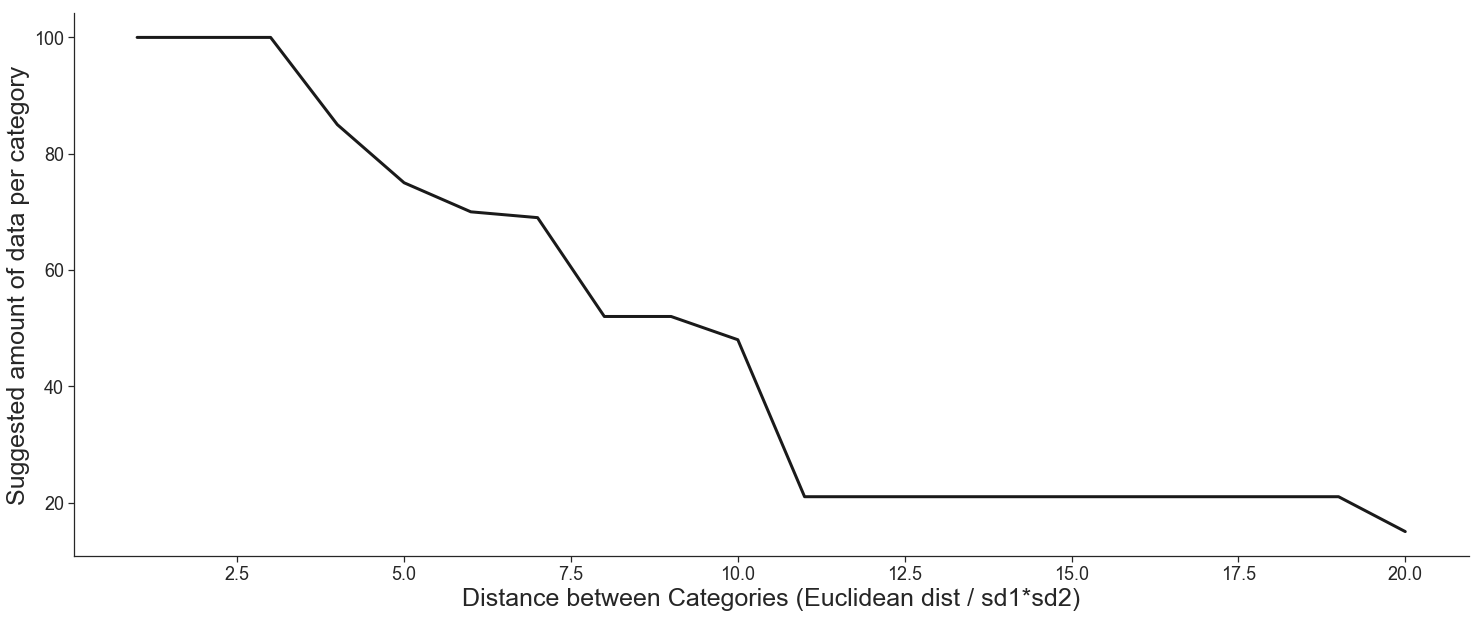

In [45]:
## plot the results

# convert dict -> dataframe
suggestionDF = pd.DataFrame(list(suggestionDict.items()), columns = ['distance', 'suggestedN']) 

# plot it:
fig = plt.figure(figsize=(25,10))
sns.set(rc={"lines.linewidth": 3, "ytick.labelsize": 18.0, "xtick.labelsize": 18.0})
sns.set_style("ticks")
ax = sns.lineplot(x = 'distance', y = 'suggestedN',
                  data = suggestionDF,
                  markers = True,
                  color = "k")

# make it pretty:
sns.despine()
ax.set_xlabel('Distance between Categories (Euclidean dist / sd1*sd2)',fontsize=25);
ax.set_ylabel('Suggested amount of data per category',fontsize=25);



# save the plot to pwd:
figName = 'SummaryDataGuidelines.png'
fig.savefig(figName, bbox_inches='tight')